**A data science experiment using data from the KDD 2010 Educational Data Mining Challenge**

The aim of this IPython Notebook is to give you a sense of the dataset.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# pyspark
import pyspark
sc = pyspark.SparkContext()
sql = pyspark.sql.SQLContext(sc)

In [2]:
from pyspark.ml.linalg import Vectors
def preprocessing(row):
    sid = row["Anon Student Id"]
    unit, section = row["Problem Hierarchy"].replace("Unit", "").replace("Section", "").replace(",", "").split()
    problem = row["Problem Name"]
    step = row["Step Name"]
    if '=' in step or '+' in step or '-' in step or '*' in step or '/' in step or '^' in step:
        step = "BasicCalculation"
    kcs = row["KC(Default)"].replace("~~", " ").replace("{", " ").replace("}", " ").replace(";", " ").replace(":", " ").replace("[", " ").replace("]", " ")\
          if row["KC(Default)"] else None
    opps = row["Opportunity(Default)"].split("~~") if row["Opportunity(Default)"] else None
    if opps:
        opp_total = 0
        for opp in opps:
            opp_total += int(opp)
        opps = opp_total / len(opps)
    view = row["Problem View"]
    cfa = row["Correct First Attempt"]
    return sid, unit, section, problem, step, view, kcs, opps, cfa
def postprocessing(point):
    feature = []
    for c in ["sid", "unit", "section", "problem", "step", "view", "opps"]:
        if c in uniqueFeatures:
            if point[c] in uniqueFeatures[c]:
                feature.extend(uniqueFeatures[c][point[c]])
            else:
                feature.extend(uniqueFeatures[c]["<unknown>"])
        else:
            feature.append(point[c])
    if point["kcs"]:
        feature.extend(vectorizer.transform([point["kcs"]]).toarray().flatten())
    else:
        feature.extend(vectorizer.transform(["<unknown>"]).toarray().flatten())
    return Vectors.dense(feature), point["cfa"]

In [3]:
# Get the data
traindata = sql.read.csv("data/train.csv", sep='\t', header=True, inferSchema=True).cache()
testdata = sql.read.csv("data/test.csv", sep='\t', header=True, inferSchema=True).cache()

In [4]:
traindata = traindata.rdd.map(preprocessing).toDF()\
                     .selectExpr("_1 as sid", "_2 as unit", "_3 as section",
                                 "_4 as problem", "_5 as step", "_6 as view",
                                 "_7 as kcs", "_8 as opps", "_9 as cfa")\
                     .fillna({"kcs":"<unknown>", "opps":0})
    
testdata = testdata.rdd.map(preprocessing).toDF()\
                   .selectExpr("_1 as sid", "_2 as unit", "_3 as section",
                               "_4 as problem", "_5 as step", "_6 as view",
                               "_7 as kcs", "_8 as opps", "_9 as cfa")\
                   .fillna({"kcs":"<unknown>", "opps":0})

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(decode_error='ignore', token_pattern=r'(?u)\b[\w/*+-=^]+\b')
vectorizer.fit([row.kcs for row in traindata.select("kcs").distinct().collect()])

featureCol = ["sid", "unit", "section", "problem", "step"]
traindata_cache = traindata.collect()
uniqueFeatures = {}

for feature in featureCol:
    uniqueFeatures[feature] = {}
    index = 0
    defaultValue = 0
    featureList = np.unique(traindata.select(feature).collect())
    
    for uniqueFeature in featureList:
        numerator, denominator = 0, 0
        for row in traindata_cache:
            if row[feature] == uniqueFeature:
                denominator += 1
                if row["cfa"] == 1:
                    numerator += 1
        cfaRate = numerator / denominator
        uniqueFeatures[feature][uniqueFeature] = (index, cfaRate)
        index += 1
        defaultValue += cfaRate
        
    defaultValue /= index
    uniqueFeatures[feature]["<unknown>"] = (index, defaultValue)

In [6]:
traindata = traindata.rdd.map(postprocessing).toDF().selectExpr("_1 as feature", "_2 as cfa")
traindata = traindata.where(traindata["cfa"].isNotNull())
testdata = testdata.rdd.map(postprocessing).toDF().selectExpr("_1 as feature", "_2 as cfa")
testdata = testdata.where(testdata["cfa"].isNotNull())

In [7]:
X_train = np.array(traindata.select("feature").collect()).reshape(-1, 203)
y_train = np.array(traindata.select("cfa").collect()).flatten()
X_test = np.array(testdata.select("feature").collect()).reshape(-1, 203)
y_test = np.array(testdata.select("cfa").collect()).flatten()

In [8]:
rmse = lambda model: np.sqrt(np.mean((model.predict(X_test) - y_test) ** 2))
acc = lambda model: 1 - np.mean(np.abs((model.predict(X_test) - y_test)))

#### LogisticRegression

In [9]:
from sklearn.linear_model import LogisticRegression
lgtr = LogisticRegression()
lgtr.fit(X_train, y_train)
rmse(lgtr), acc(lgtr)

/home/tony/project-injoker/.venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.4332293707583636, 0.8123123123123124)

#### LinearRegression

In [10]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)
rmse(lr)

0.3656166731527155

#### NeuralNet

In [11]:
from sklearn.neural_network import MLPRegressor
mlpr = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic', solver='adam', learning_rate='invscaling')
mlpr.fit(X_train, y_train)
rmse(mlpr)

0.3618360408148614

#### K-NearestNeighbor

Text(0, 0.5, 'RMSE')

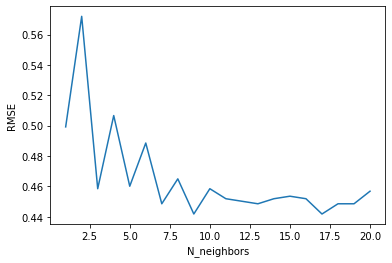

In [12]:
from sklearn.neighbors import KNeighborsClassifier
loss = []
for i in range(1, 21):
    knc = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knc.fit(X_train, y_train)
    loss.append(rmse(knc))
plt.plot(range(1, 21), loss)
plt.xlabel("N_neighbors")
plt.ylabel("RMSE")

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=16, n_jobs=-1)
knc.fit(X_train, y_train)
rmse(knc), acc(knc)

(0.45188959293637665, 0.7957957957957957)

Text(0, 0.5, 'RMSE')

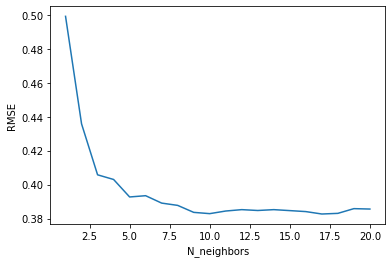

In [15]:
from sklearn.neighbors import KNeighborsRegressor
loss = []
for i in range(1, 21):
    knr = KNeighborsRegressor(n_neighbors=i, n_jobs=-1)
    knr.fit(X_train, y_train)
    loss.append(rmse(knr))
plt.plot(range(1, 21), loss)
plt.xlabel("N_neighbors")
plt.ylabel("RMSE")

In [16]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(n_neighbors=16, n_jobs=-1)
knr.fit(X_train, y_train)
rmse(knr)

0.38410187841639487

#### DecisionTreeRegressor

Text(0, 0.5, 'RMSE')

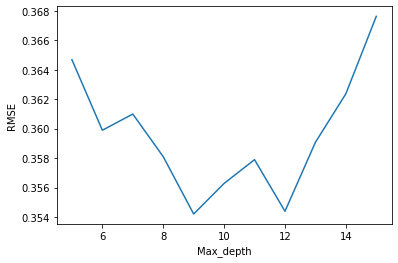

In [18]:
from sklearn.tree import DecisionTreeRegressor
loss = []
for i in range(5, 16):
    dtr = DecisionTreeRegressor(max_depth=i, presort=True)
    dtr.fit(X_train, y_train)
    loss.append(rmse(dtr))
plt.plot(range(5, 16), loss)
plt.xlabel("Max_depth")
plt.ylabel("RMSE")

In [19]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=9, presort=True)
dtr.fit(X_train, y_train)
rmse(dtr)

0.3542033785972317

#### RandomForest

Text(0, 0.5, 'RMSE')

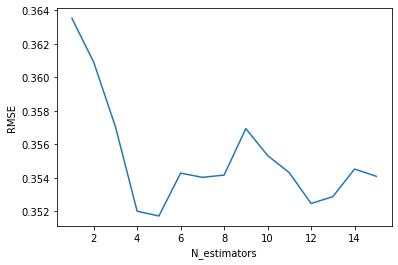

In [23]:
from sklearn.ensemble import RandomForestRegressor
# loss = []
for i in range(1, 16):
    rfr = RandomForestRegressor(max_depth=9, n_estimators=i, n_jobs=-1)
    rfr.fit(X_train, y_train)
    loss.append(rmse(rfr))
plt.plot(range(1, 16), loss)
plt.xlabel("N_estimators")
plt.ylabel("RMSE")

In [26]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=9, n_estimators=5, n_jobs=-1)
rfc.fit(X_train, y_train)
rmse(rfc), acc(rfc)

(0.4173417953838007, 0.8258258258258259)

In [21]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=9, n_estimators=5, n_jobs=-1)
rfr.fit(X_train, y_train)
rmse(rfr)

0.3534500736156388

#### Fill test.csv

In [11]:
testdata = sql.read.csv("data/test.csv", sep='\t', header=True, inferSchema=True).cache()
pre = testdata.rdd.map(preprocessing).toDF()\
                   .selectExpr("_1 as sid", "_2 as unit", "_3 as section",
                               "_4 as problem", "_5 as step", "_6 as view",
                               "_7 as kcs", "_8 as opps", "_9 as cfa")\
                   .fillna({"kcs":"<unknown>", "opps":0})
post = pre.rdd.map(postprocessing).toDF().selectExpr("_1 as feature", "_2 as cfa")
X_target = np.array(post.select("feature").collect()).reshape(-1, 203)
y_target = np.array(post.select("cfa").collect()).flatten()
predicted = rfr.predict(X_target)
for (i, y) in enumerate(y_target):
    if y == None:
        y_target[i] = predicted[i]

testdata = testdata.toPandas()
testdata["Correct First Attempt"] = y_target
testdata.to_csv("test.csv", sep="\t", index=False)